# Project 1: Conspiracy Theories - Reddit

<p style="font-size:20px;">Daniel Cho</p>

In [1]:
import re
from collections import Counter, defaultdict

import nltk
import numpy as np
import pandas as pd
from cytoolz import concat
from tqdm import tqdm

In [2]:
df = pd.read_pickle("/data/conspiracy.pkl")
df

,date,text
0,2019-08-09 21:58:14,Your post has been removed because it does not...
1,2022-01-15 19:16:00,Ugh. I am sick of seeing his face. He is so co...
2,2022-10-24 16:25:16,"I’m not saying charges weren’t used, what I am..."
3,2016-10-28 15:10:41,It's actually a callback to Tom Cruise's momen...
4,2020-12-12 19:53:11,All caps titles are not permitted as per rule ...
...,...,...
19993,2022-03-03 07:03:00,Cry me a river. I'm speaking from my personal ...
19994,2021-02-13 08:04:35,What’s the conspiracy? All I see are political...
19995,2016-12-06 19:21:36,Remind people that this shit is larger and mor...
19996,2015-12-06 16:25:01,> you do not have time to go tell nasa yoursel...


From the spacy library, we will initialize the matcher object and load the English language model.

In [3]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load(
    "en_core_web_sm", exclude=["parser", "ner", "lemmatizer", "attribute_ruler"]
)

We will initialize the matcher object and add a custom speech pattern. We will then define our get_phrases function to take a document as an input and extract the patterns as defined in matcher.

In [4]:
matcher = Matcher(nlp.vocab)
matcher.add(
    "Term",
    [
        [
            {"TAG": {"IN": ["JJ", "NN", "NNS", "NNP"]}},
            {"TAG": {"IN": ["JJ", "NN", "NNS", "NNP", "HYPH"]}, "OP": "*"},
            {"TAG": {"IN": ["NN", "NNS", "NNP"]}},
        ]
    ],
)


def get_phrases(doc):
    spans = matcher(doc, as_spans=True)
    return [tuple(tok.norm_ for tok in span) for span in spans]

### Find Candidate Terms

In [5]:
docs = nlp.pipe(tqdm(df["text"]), n_process=2, batch_size=5)
candidates = Counter(concat(get_phrases(d) for d in docs))

100%|██████████| 19969/19969 [07:09<00:00, 46.47it/s] 


In [8]:
candidates.most_common(10)

[(('submission', 'statement'), 6577),
 (('many', 'people'), 2460),
 (('same', 'thing'), 2090),
 (('*', '*'), 1936),
 (('social', 'media'), 1847),
 (('█', '█'), 1743),
 (('█', '█', '█'), 1706),
 (('united', 'states'), 1690),
 (('█', '█', '█', '█'), 1671),
 (('█', '█', '█', '█', '█'), 1637)]

### Use C-Value algorithm to find terms

In [7]:
freqs = defaultdict(Counter)
for c in candidates:
    freqs[len(c)][c] += candidates[c]

In [9]:
def get_subterms(term):
    k = len(term)
    for m in range(k - 1, 1, -1):
        yield from nltk.ngrams(term, m)


def c_value(F, theta):

    termhood = Counter()
    longer = defaultdict(list)

    for k in sorted(F, reverse=True):
        for term in F[k]:
            if term in longer:
                discount = sum(longer[term]) / len(longer[term])
            else:
                discount = 0
            c = np.log2(k) * (F[k][term] - discount)
            if c > theta:
                termhood[term] = c
                for subterm in get_subterms(term):
                    if subterm in F[len(subterm)]:
                        longer[subterm].append(F[k][term])
    return termhood

In [10]:
terms = c_value(freqs, theta=50)

### Save Terms

In [11]:
with open("terms.txt", "w") as f:
    for term in terms:
        print(" ".join(term), file=f)

### Second part of tokenization

We will now tokenize texts using the terms we just found that is stored in our text file.

In [12]:
from tokenizer import MWETokenizer

tokenizer = MWETokenizer(t.strip() for t in open("terms.txt"))

In [13]:
df["tokens"] = [tokenizer.tokenize(txt) for txt in tqdm(df["text"])]

100%|██████████| 19969/19969 [00:55<00:00, 358.14it/s]


### Topic Model

In [14]:
import tomotopy as tp

In [15]:
k = 50
min_df = 50
rm_top = 150
tw = tp.TermWeight.ONE
alpha = 0.1
eta = 0.01
tol = 1e-4

rm_topic was tested at 50, 100, and 150. At 50 and 100, there were many words that did not relate to conspiracy topics, where it removed those words at a value of 150.

In [16]:
%%time

mdl = tp.LDAModel(k=k, min_df=min_df, rm_top=rm_top, tw=tw, alpha=alpha, eta=eta)

for toks in df["tokens"]:
    mdl.add_doc(toks)

mdl.train(0)
last = mdl.ll_per_word
print(f"{0:5d} LL = {last:8.4f}", flush=True)

for i in range(50, 5000, 50):
    mdl.train(50, workers=4)
    ll = mdl.ll_per_word
    print(f"{i:5d} LL = {ll:8.4f}", flush=True)
    if ll - last < tol:
        break
    else:
        last = ll

    0 LL = -12.8682
   50 LL =  -9.5797
  100 LL =  -9.4071
  150 LL =  -9.3200
  200 LL =  -9.2761
  250 LL =  -9.2484
  300 LL =  -9.2297
  350 LL =  -9.2151
  400 LL =  -9.2044
  450 LL =  -9.1945
  500 LL =  -9.1909
  550 LL =  -9.1848
  600 LL =  -9.1807
  650 LL =  -9.1774
  700 LL =  -9.1780
CPU times: user 6min 43s, sys: 1.05 s, total: 6min 44s
Wall time: 1min 56s


#### Examine the Model

In [17]:
", ".join(mdl.removed_top_words)

"the, to, and, a, of, not, i, is, you, it, that, in, are, 's, they, this, for, have, do, on, was, be, with, but, if, as, what, or, people, just, all, he, can, we, so, your, like, about, there, will, from, would, at, no, by, am, who, their, an, has, one, my, because, think, how, up, more, out, them, get, when, me, know, does, >, been, were, some, why, his, even, then, any, us, being, see, now, than, here, also, had, which, going, these, could, only, right, u_r_l, into, make, want, did, really, should, say, those, well, most, over, trump, go, time, our, said, its, much, way, something, him, where, other, still, very, too, never, believe, need, actually, got, she, take, look, shit, anything, sure, years, after, down, back, someone, world, point, off, post, same, every, good, before, things, government, lol, saying, nothing, many, made, mean, use, her, lot, everyone"

We can see that we removed a lot of words that are not related to conspiracy topics.

In [18]:
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.manifold import MDS, TSNE


def plot_topics(mdl, method="tsne", figsize=7):

    fig = plt.figure(figsize=(figsize, figsize))

    # x, y coords
    term_topics_dist = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
    if method == "mds":
        dist = distance.squareform(distance.pdist(term_topics_dist, "jensenshannon"))
        coords = MDS(2, dissimilarity="precomputed").fit_transform(dist)
    elif method == "tsne":
        if mdl.k <= 20:
            p = mdl.k - 1
        else:
            p = 20
        coords = TSNE(
            2,
            metric=distance.jensenshannon,
            perplexity=p,
            init="pca",
            learning_rate="auto",
            n_jobs=-1,
        ).fit_transform(term_topics_dist)
    else:
        raise ValueError(f"Method {method} unknown")

    # size of the circle
    doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
    doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
    words_per_topic = np.dot(doc_topic_dists.T, doc_lengths)
    topic_percent = words_per_topic / words_per_topic.sum()
    sizes = topic_percent * (figsize * fig.dpi) * (figsize * fig.dpi) * (0.25 / 3.14)

    # draw it
    plt.scatter(coords[:, 0], coords[:, 1], s=sizes, alpha=0.3)
    for i in range(mdl.k):
        plt.text(coords[i, 0], coords[i, 1], i, ha="center", va="center")

        plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

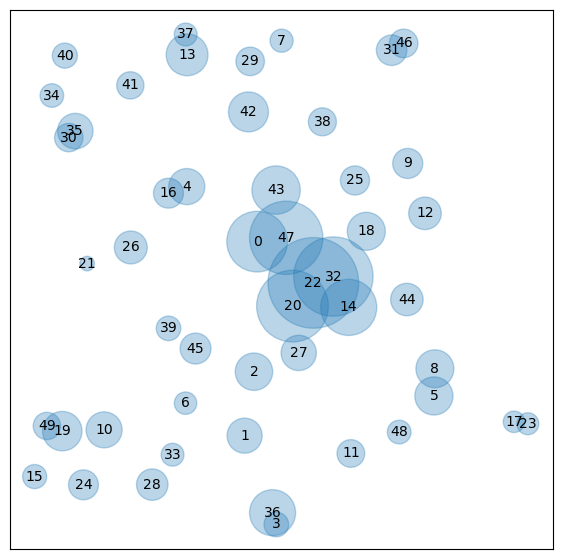

In [19]:
plot_topics(mdl)

We can see here that the topics are spaced out relatively well with the exception of the large clusters in the middle. After some investigation, this cluster are topics that were created from words that do not describe a conspiracy topic. We can see that further in the next steps.

#### Interpreting the Model
What terms are associated with each topic? =  𝑝(𝑤|𝑧)

In [20]:
for k in range(mdl.k):
    print(f"{k:3d} ", ", ".join(s for s, _ in mdl.get_topic_words(k)))

  0  society, agree, own, person, such, others, different, idea, understand, both
  1  1, 2, +, number, =, numbers, data, million, 10, 5
  2  live, city, 2, home, area, 3, day, year, hours, ago
  3  money, gold, debt, buy, bank, banks, currency, value, $, cash
  4  law, state, laws, rights, freedom, legal, country, constitution, states, against
  5  sub, reddit, conspiracy, posts, r, /r, comments, banned, shills, comment
  6  car, technology, cars, g, energy, gas, 5, power, nuclear, tesla
  7  q, cia, fbi, information, snowden, nsa, qanon, assange, documents, anonymous
  8  article, read, link, find, thanks, source, links, posted, information, site
  9  movie, show, music, watch, hollywood, book, film, movies, documentary, great
 10  covid, deaths, death, died, die, hospital, flu, year, data, cases
 11  data, phone, google, using, access, internet, information, computer, ai, used
 12  god, bible, jesus, religion, satan, christian, religious, evil, church, man
 13  biden, president, oba

We can see the various key words in each topic. However, we need to label these groups to specify its respective topic.

In [21]:
mdl.save("conspiracy-topics.bin")

In [22]:
topic_words = [[x for x, _ in mdl.get_topic_words(i)] for i in range(mdl.k)]
topics = pd.DataFrame(
    {
        "label": [x[0].upper() for x in topic_words],
        "words": [", ".join(x) for x in topic_words],
    }
)
topics.to_csv("con_labels.csv", index=False)

We can take the first key word in each group as our default topic label, and store this dataframe as a csv file for further evaluation. The csv file makes it easier for us to edit the topic labels if we find that a different label can best summarize the group of words.

We can see that some of the labels can be changed to better generalize the topic words.

In [23]:
topics

,label,words
0,SOCIETY,"society, agree, own, person, such, others, dif..."
1,1,"1, 2, +, number, =, numbers, data, million, 10, 5"
2,LIVE,"live, city, 2, home, area, 3, day, year, hours..."
3,MONEY,"money, gold, debt, buy, bank, banks, currency,..."
4,LAW,"law, state, laws, rights, freedom, legal, coun..."
5,SUB,"sub, reddit, conspiracy, posts, r, /r, comment..."
6,CAR,"car, technology, cars, g, energy, gas, 5, powe..."
7,Q,"q, cia, fbi, information, snowden, nsa, qanon,..."
8,ARTICLE,"article, read, link, find, thanks, source, lin..."
9,MOVIE,"movie, show, music, watch, hollywood, book, fi..."


After editing the labels, we can save it and store it back into the topics dataframe.

In [24]:
topics = pd.read_csv("con_labels.csv")
topics

,label,words
0,IDEAS,"society, agree, own, person, such, others, dif..."
1,NUMBERS,"1, 2, +, number, =, numbers, data, million, 10, 5"
2,NON_TOPIC_1,"live, city, 2, home, area, 3, day, year, hours..."
3,MONEY_BANK,"money, gold, debt, buy, bank, banks, currency,..."
4,LAW,"law, state, laws, rights, freedom, legal, coun..."
5,REDDIT_1,"sub, reddit, conspiracy, posts, r, /r, comment..."
6,ELECTRIC_CARS,"car, technology, cars, g, energy, gas, 5, powe..."
7,CIA/FBI,"q, cia, fbi, information, snowden, nsa, qanon,..."
8,SOURCES,"article, read, link, find, thanks, source, lin..."
9,MOVIE/TV,"movie, show, music, watch, hollywood, book, fi..."


In [25]:
labels = list(pd.read_csv("con_labels.csv")["label"])

In [26]:
df["doc"] = [mdl.make_doc(words=toks) for toks in df["tokens"]]
topic_dist, ll = mdl.infer(df["doc"])

In [27]:
def first(x):
    return x[0]

df["topics"] = [
    [labels[t] for t in map(first, d.get_topics(3))] for d in df["doc"]
]

In [39]:
topic_freq = Counter(concat(df["topics"]))
topic_freq.most_common()

[('NON_TOPIC_3', 9900),
 ('NON_TOPIC_5', 6663),
 ('LIFE', 3789),
 ('NON_TOPIC_2', 3104),
 ('EVIDENCE', 2757),
 ('IDEAS', 1975),
 ('REDDIT_3', 1843),
 ('SOURCES', 1825),
 ('POWER', 1667),
 ('U.S.', 1325),
 ('NON_TOPIC_4', 1227),
 ('REDDIT_1', 1206),
 ('DEM/REP', 1142),
 ('MOVIE/TV', 1069),
 ('RUSSIA_UKRAINE', 1041),
 ('MONEY_TAX', 1040),
 ('NON_TOPIC_1', 1032),
 ('VIDEO/PHOTO', 954),
 ('REDDIT_2', 914),
 ('REALITY', 899),
 ('VACCINE', 887),
 ('LAW', 753),
 ('SPACE', 702),
 ('POLICE', 697),
 ('GOD', 695),
 ('DATA/INFORMATION', 661),
 ('CONSPIRACY', 630),
 ('COVID_DEATH', 628),
 ('NUMBERS', 559),
 ('IDEOLOGY', 528),
 ('FOOD/DIET', 505),
 ('MEDIA', 500),
 ('COURT_SYSTEM', 490),
 ('ISRAEL', 489),
 ('EPSTEIN', 483),
 ('CIA/FBI', 477),
 ('RUSSIA_HILARY', 447),
 ('MONEY_BANK', 440),
 ('SOCIAL_MEDIA', 401),
 ('BLM', 387),
 ('VIRUS', 366),
 ('SCIENCE', 364),
 ('9/11', 356),
 ('KIDS', 355),
 ('ENERGY_CLIMATE', 340),
 ('ELECTRIC_CARS', 329),
 ('MASKS', 327),
 ('WHITE/BLACK', 312),
 ('ELECTION', 28

We can see that the non_topic labels have the highest frequency, which suggests that our model can be improved to remove other English words. However, we can see that the topics life, evidence and ideas also have high frequency. If we investigate the words that are in these topics, we can see that these words are used often when one is presenting an idea, providing evidence, and how that conspiracy affects the lives of certain people. If we take a look at the topics that are less frequent, we can then see which conspiracy topics are more "popular" or discussed in this subreddit. 

We can also use a bar chart to visualize the frequency of topics that are sorted from highest frequency to lowest for the top 10 topics.

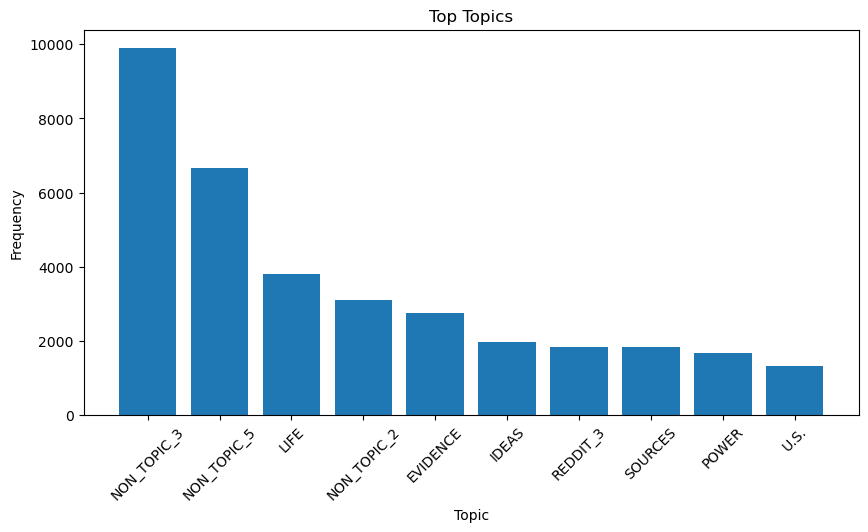

In [40]:
topic_freq = Counter(concat(df["topics"]))
top_topics = topic_freq.most_common(10)

# Extract topics and frequencies
topics, freqs = zip(*top_topics)

# Create bar plot
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(topics, freqs)
ax.set_title("Top Topics")
ax.set_xlabel("Topic")
ax.set_ylabel("Frequency")

plt.xticks(rotation=45)

# Show plot
plt.show()

In [41]:
results = []

for i in range(len(df)):
    doc = df["doc"].iloc[i]
    topics_doc = doc.get_topics(top_n=5)
    labeled_topics = [(labels[x], y) for x, y in topics_doc]
    results.append(labeled_topics)
    
df["top_topics"] = results

We can also visualize the topic distribution by document, where we can alter the code to select which documents we want to see. As an example, this is the topic distribution of the first 5 documents in our dataset.

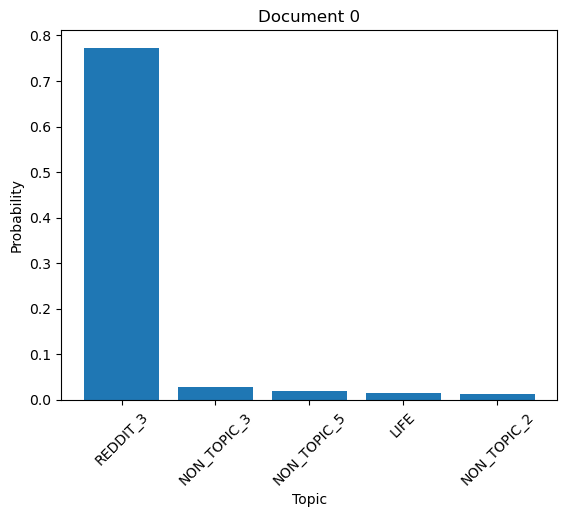

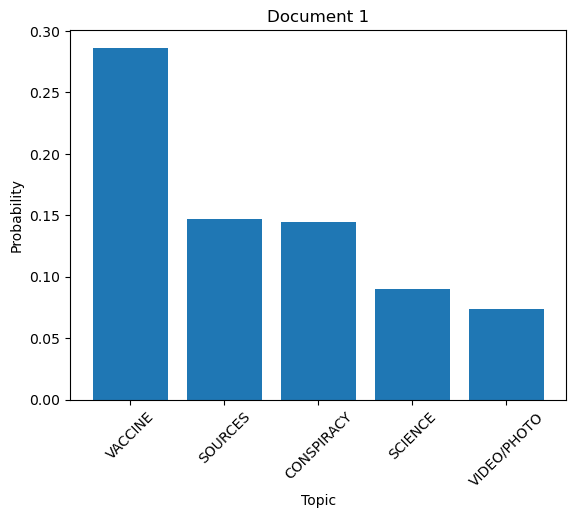

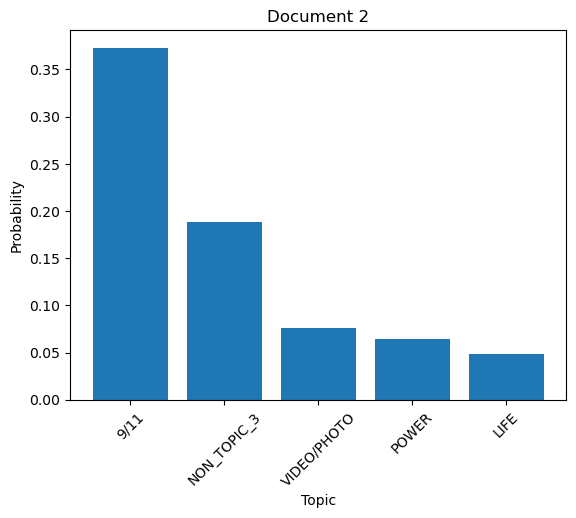

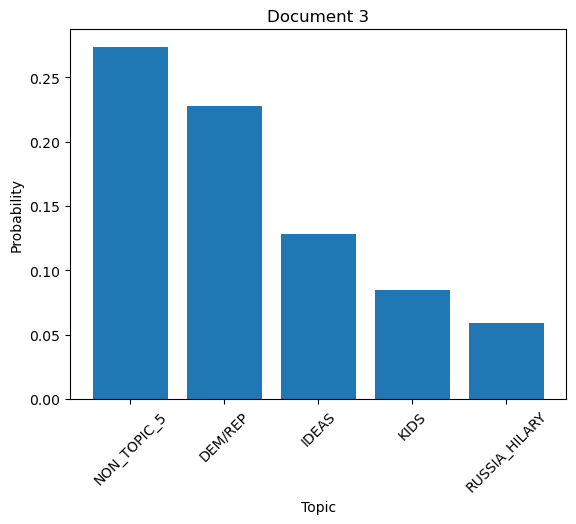

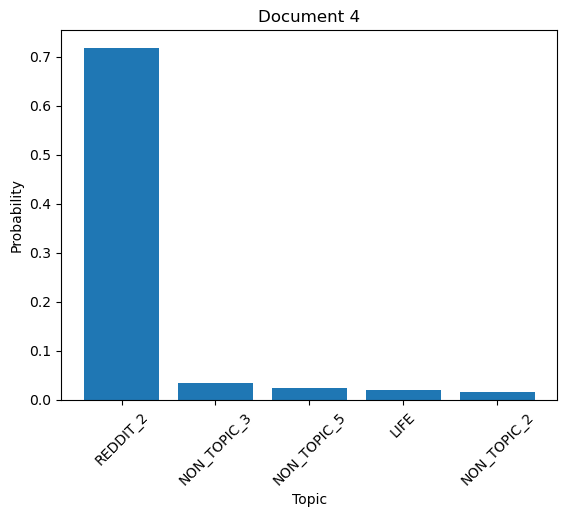

In [42]:
top_topics = df["top_topics"].iloc[:5]

# Loop over each document
for i, doc_topics in enumerate(top_topics):
    # Extract topics and probabilities
    topics_doc, probs = zip(*doc_topics)
    
    # Create bar plot
    fig, ax = plt.subplots()
    ax.bar(topics_doc, probs)
    ax.set_title(f"Document {i}")
    ax.set_xlabel("Topic")
    ax.set_ylabel("Probability")
    
    plt.xticks(rotation=45)
    
    # Show plot
    plt.show()

### Topic Evolution with Time Series Analysis

We can also do a time series analysis of a topic to gain more insight on what topics were more or less prominent over the years. With that information, we can see how the peoples' interests have changed over time, and possibly be able to link the topic with other driving factors.

In [ ]:
%%time

docs = [mdl.make_doc(words=toks) for toks in df["tokens"]]
topic_dist, ll = mdl.infer(docs)
topics = [d.get_topic_dist() for d in docs]

First, we will prepare our topic distributions for extraction, so we can visualize the distribution against the date of the document.

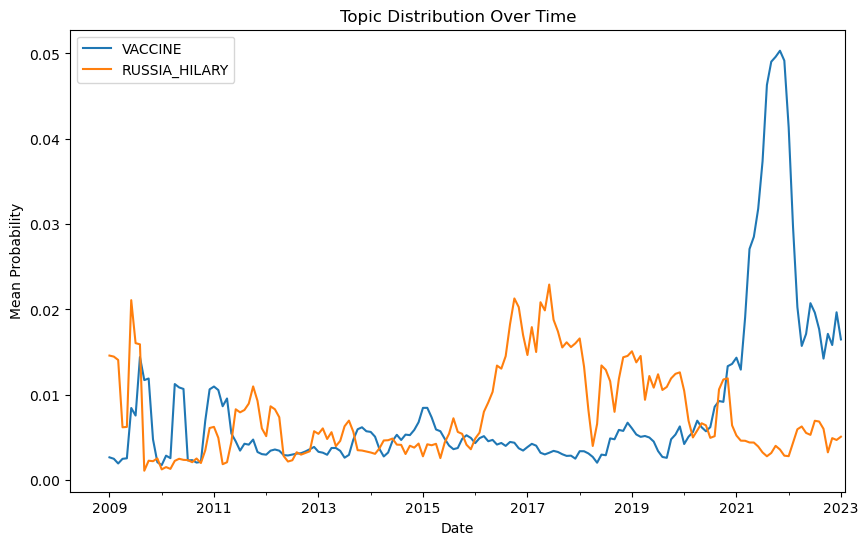

In [49]:
# Extract topic distributions for Topics 15, 17, and 22
df["VACCINE"] = [t[19] for t in topics]
df["RUSSIA_HILARY"] = [t[29] for t in topics]
#df["POLICE"] = [t[26] for t in topics]

# Resample by month and take the mean for each month
monthly_means = df.resample("M", on="date")[['VACCINE','RUSSIA_HILARY']].mean()

# Apply a rolling of 3
rolling_means = monthly_means.rolling(3, center=True).mean()

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
rolling_means.plot(ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Mean Probability")
ax.set_title("Topic Distribution Over Time")
plt.show()

This graph shows the distribution of the topics vaccine and russia_hillary by the dates of the documents. We can see that the topic vaccine has a huge spike from 2021 to 2022, where this was during the time of the COVID pandemic. During this time, the CDC and government pushed for all Americans to take the vaccine, which created space for many anti-vaccine activists and conspiracists.

We can also see that the topic Russia_Hilary has a spike from 2016 to 2017, which followed the 2016 presidential election. In short, there was an alleged collusion between the Russian government and the Trump campaign to use cyber attacks on Hillary Clinton's presidential campaign.

It was interesting to see that this topic model actually reflected past events in the time series analysis. However, we can see that there are limitations because there is data shown before the actual event of what the topic represents. This is due to the fact that the topic labels consist of various words that could have been used to describe a similar, but different topic. For example, the russia_hilary topic includes the words, "cia, fbi, russia, investigation". These words do not explicitly describe the conspiracy of the 2016 presidential campaign, and can be used for other topics. 